In [1]:
!pip install einops
%load_ext autoreload
%autoreload 2

import seaborn as sns
from dataclasses import dataclass
import matplotlib.pyplot as plt

import datautils
from utils import init_dl_program
from utils import find_closest_train_segment
from hdst import HDST
import torch
import gc
import numpy as np

  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)


## Create Args Configuration Class

In [56]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = 200

    run_name: str = ""
    batch_size: int = 16
    lr: float = 0.001
    max_train_length = 800
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0
    mask_mode: str ='all_false'

    sample_size: int = 10
    window_size: int = None # Use None for multi-scale
    top_k: int =2 # Use the top k prominent periodicity as time scale. If use sepcified window size, you can set top_k as random number.

## Instantiate Args Configuration Class
Create an instance of arguments, specifying the necessary arguments and those important to your use case.

In [57]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0,
        'global_vatiant_contrast': 0,
        'dynamic_trend_pred': 1,
    },
    eval=False,
    batch_size=16,
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)

## Load your data
You can use any data, as long as it is an `np.ndarray` of shape $(N, T, C)$ where $N$ is the number of time-series instances, $T$ the number of timesteps per instance, and $C$ the number of channels.
Choosing from 'ETTh1', 'ETTh2', 'ETTm1' and 'ETTm2'

In [58]:
data, train_slice, valid_slice, test_slice, scaler, pred_lens = datautils.load_forecast_csv("ETTm2")
train_data = data[:, train_slice]
test_data = data[:, test_slice]
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")
print(pred_lens)

Shapes - train data: (1, 34560, 7), test data: (1, 11520, 7)
[24, 48, 96, 288, 672]


## Create and Train the model

In [59]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

8596

In [60]:
import time
start_time = time.time()
model = HDST(
    input_dims=train_data.shape[-1],
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length,
    mask_mode=args.mask_mode
)

loss_log = model.fit(
    train_data,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size
)
end_time = time.time()
training_time = end_time - start_time
print(f"Model training time: {training_time:.2f} seconds")

Training data shape: (43, 804, 7)
[800 100]


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 21.98 GiB of which 20.44 MiB is free. Process 10139 has 21.95 GiB memory in use. Of the allocated memory 21.62 GiB is allocated by PyTorch, and 17.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Save model and loss log

In [42]:
import torch
torch.save(model, 'logs/mymodel_ETTh1.pth')
import pandas as pd
df = pd.DataFrame({"epoch": list(range(1, len(loss_log) + 1)), "loss": loss_log})
df.to_csv("logs/loss_log_ETTh1.csv", index=False)

PicklingError: Can't pickle <class 'hdst.HDST'>: it's not the same object as hdst.HDST

Visualize the loss curve and save figure

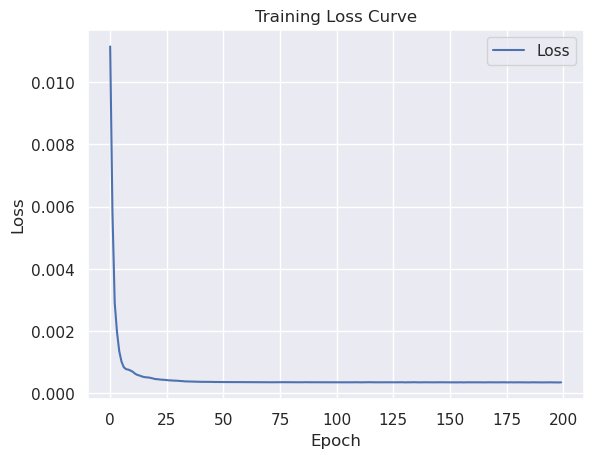

In [43]:
import matplotlib.pyplot as plt
# print(loss_log)
plt.plot(loss_log, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

## Test the model
Firstly, get the representation of training data and test data using `model.encode`. Then train a Ridge regression model using training representation and corresponding training labels. Finally, use the Ridge regression model to do forecasting for test representation. Report the MSE and MAE.

In [44]:
from tasks.forecasting import eval_forecasting
out, eval_res = eval_forecasting(
                model,
                data,
                train_slice,
                valid_slice,
                test_slice,
                scaler,
                pred_lens
            )
res=eval_res['ours']
for key, value in res.items():
    print(f"{key}: {value}")


24: {'norm': {'MSE': 0.5221265021376841, 'MAE': 0.49021243114317603}, 'raw': {'MSE': 8.403524344375066, 'MAE': 1.619006997742756}}
48: {'norm': {'MSE': 0.5564734384032962, 'MAE': 0.5182026704256829}, 'raw': {'MSE': 9.755398978818453, 'MAE': 1.7846086694014138}}
168: {'norm': {'MSE': 0.7612500244549, 'MAE': 0.6387946538945894}, 'raw': {'MSE': 12.983529636316216, 'MAE': 2.1916591050428265}}
336: {'norm': {'MSE': 0.9438993039169362, 'MAE': 0.7347592558044547}, 'raw': {'MSE': 14.694213147090585, 'MAE': 2.4302129775371673}}
720: {'norm': {'MSE': 1.106779682029439, 'MAE': 0.824015972263231}, 'raw': {'MSE': 15.630086901046955, 'MAE': 2.6809399835433685}}
